## Lighthouse Labs
### W05D02 Logistic Regression
Instructor: Socorro Dominguez  
February 02, 2021

In [1]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_boston

import numpy as np
import pandas as pd
from plot_classifier import plot_classifier
import matplotlib.pyplot as plt
%matplotlib inline

**Agenda:**

* "Express" Review of Linear Regression

* Limitations of Linear Regression

* Logistic regression
    * Odds
    * Log-odds
    * Odds ratio
    
* GLM (generalised linear models)

## Fast Review of Linear Regression

Let's imagine we have a dataset of Height and Weight. Let Height be our feature and Weight our Target Variable.

In [2]:
df = pd.read_csv('data/weight-height.csv', usecols = ['Height', 'Weight'])
df.head(10)

,Height,Weight
0,73.847017,241.893563
1,68.781904,162.310473
2,74.110105,212.740856
3,71.730978,220.042470
4,69.881796,206.349801
5,67.253016,152.212156
6,68.785081,183.927889
7,68.348516,167.971110
8,67.018950,175.929440
9,63.456494,156.399676


In [3]:
# Initializing a LR model
rm = Ridge()
X_train = df['Height'].values.reshape(-1, 1)
y_train = df['Weight']

In [4]:
rm.fit(X_train, y_train);

In [5]:
rm.predict(X_train)[:5]

array([219.16108997, 180.07242032, 221.19140492, 202.83112165,
       188.56054448])

In [6]:
rm.score(X_train, y_train)

0.8551742120219649

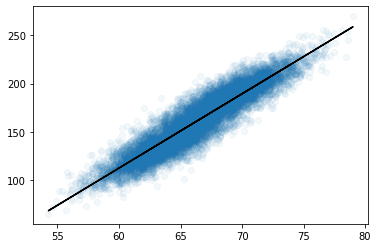

In [7]:
plt.scatter(X_train, y_train, alpha=0.05)
plt.plot(X_train, (rm.coef_*X_train)+rm.intercept_, c='black')

So? How were we able to plot?

## Coefficients and Intercepts

The intuition behind Linear Regression lies behind the Coefficients and Intercepts.

Some people call the Coefficients to be the Weights (different jargon). This 'Weights' and 'Intercept' is what is being learned during `fit`.

That's also true for Logistic Regression and the reasoning to do this review. 

Let's bring in a Dataset with more features for this fast review.

In [8]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns = boston.feature_names)
y = pd.DataFrame(boston.target, columns=['TARGET'])

In [9]:
lr = Ridge()
lr.fit(X,y)

Ridge()

In [10]:
lr.score(X,y)

0.7388703133867616

In [11]:
ridge_coeffs = lr.coef_

In [12]:
words_coeffs_df = pd.DataFrame(data = ridge_coeffs.T, index = X.columns, columns=['Coefficients'])
words_coeffs_df

,Coefficients
CRIM,-0.104595
ZN,0.047443
INDUS,-0.008805
CHAS,2.552393
NOX,-10.777015
RM,3.854000
AGE,-0.005415
DIS,-1.372654
RAD,0.290142
TAX,-0.012912


CAREFUL : This data has not been scaled. Not having similar measures, makes it hard for comparison.

Without scaling... what do you think would happen if Age was in seconds?

Let’s try to make some sense of it here!

We can use these coefficients to interpret our model. They show us how much each of these features affects our model’s prediction.

For example, if we had a house with 2 RM (number of rooms per dwelling), our RM value is 2. That means that $2*3.854$ will be contributed to our predicted price. 

The negative coefficients work in the opposite way, if we have a house where DIS (weighted distances to five Boston employment centres) is 10, that would contribute $10*-1.3726$ to our house price.

**IMPORTANT**
In linear models:

* if the coefficient is +, then ↑ the feature values ↑ the prediction value.
* if the coefficient is -, then ↑ the feature values ↓ the prediction value.
* if the coefficient is 0, the feature is not used in making a prediction.

## Predicting

In [13]:
X.iloc[0:1]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98


In [14]:
lr.predict(X.iloc[0:1])

array([[30.25311604]])

## Coefficients Reminders

In [15]:
pd.DataFrame(data = ridge_coeffs, columns = X.columns)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.104595,0.047443,-0.008805,2.552393,-10.777015,3.854,-0.005415,-1.372654,0.290142,-0.012912,-0.876074,0.009673,-0.533343


In [16]:
(ridge_coeffs * X.iloc[0:1]).sum(axis=1) + lr.intercept_

0    30.253116
dtype: float64

### Limitations for Linear Regression

In Regression, we allow the response to take on any real number. But what if the range is restricted?

1. Positive values: river flow. 
    - Lower limit: 0
2. Percent/proportion data: proportion of income spent on housing in Vancouver. 
    - Lower limit: 0
    - Upper limit: 1. 
3. Binary data: success/failure data.
    - Only take values of 0 and 1.
4. Count data: number of male crabs nearby a nesting female
    - Only take count values (0, 1, 2, ...)

Notice the problem here -- __the regression lines extend beyond the possible range of the response__. This is *mathematically incorrect*, since the expected value cannot extend outside of the range of Y. But what are the *practical* consequences of this?

In practice, when fitting a linear regression model when the range of the response is restricted, we lose hope for extrapolation, as we obtain logical fallacies if we do. In this example, a cow is expected to produce _negative_ fat content after week 40!

Despite this, a linear regression model might still be useful in these settings. After all, the linear trend looks good for the range of the data. 


### Logistic Regression

The first thing to say is that logistic regression is not a regression, but a classification learning algorithm. The name comes from statistics and is due to the fact that the mathematical formulation of logistic regression is similar to that of linear regression.

- A linear model for classification. 
- It learns weights associated with each feature and the bias. 
- The decision boundary is a hyperplane dividing the feature space in half. That's why we call it a linear classifier.

### Explanation of Log Reg using USA and Canada Lat Long data


In [17]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["country"], axis=1), train_df["country"]
X_test, y_test = test_df.drop(columns=["country"], axis=1), test_df["country"]

In [18]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

### Decision boundary of logistic regression

The decision boundary is a hyperplane dividing the feature space in half.

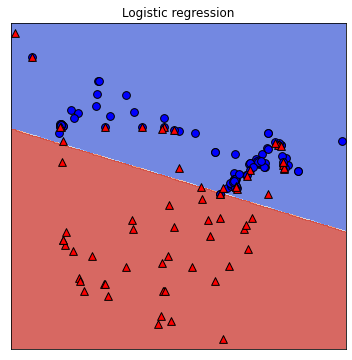

In [19]:
plt.figure(figsize=(6, 6))
plot_classifier(X_train, y_train, lr, ax=plt.gca())
plt.title("Logistic regression");

### Accessing learned weights

- Recall that logistic regression learns the weights $w$ and bias or intercept $b$

\begin{equation}
\begin{split}
z =& w_1x_1 + \dots w_dx_d + b\\
=& w^Tx + b
\end{split}
\end{equation}

- How to access these weights? 
    - In `sklearn`, the `coef_` attribute of the `LogisticRegression` object gives the weights of the features.

In [20]:
X_train.columns

Index(['longitude', 'latitude'], dtype='object')

In [21]:
print("Model weights: %s"%(lr.coef_)) # these are weights
print("Model intercept: %s"%(lr.intercept_)) # this is the bias term
data = {'features': X_train.columns, 'coefficients':lr.coef_[0]}
pd.DataFrame(data)

Model weights: [[-0.04108149 -0.33683126]]
Model intercept: [10.8869838]


,features,coefficients
0,longitude,-0.041081
1,latitude,-0.336831


- Both negative weights 
- The weight of latitude is larger in magnitude. 

### Prediction with learned weights

In [22]:
example = X_test.iloc[0,:]
example.tolist()

[-64.8001, 46.098]

In [23]:
lr.intercept_

array([10.8869838])

Calculate $\hat{y}$ as: ```y_hat = np.dot(w, x) + b```

In [24]:
np.dot(example.tolist(), lr.coef_.flatten()) + (lr.intercept_)

array([-1.97817876])

In [25]:
lr.classes_

array(['Canada', 'USA'], dtype=object)

- Our threshold here is 0
- The sign is negative and so predict class -1 (Canada in our case). 

In [26]:
lr.predict([example])

array(['Canada'], dtype=object)

### Scores to probabilities 

- The numbers we saw above are "raw model output".
- For linear regression this would have been the prediction.
- For logistic regression, you check the **sign** of this value.
  - If positive, predict $+1$; if negative, predict $-1$.
  - These are "hard predictions".
- You can also have "soft predictions", aka predicted probabilities. 
  - To convert the raw model output into probabilities, instead of taking the sign, we apply the sigmoid.

#### The sigmoid function 
- The sigmoid function "squashes" the raw model output from any number to the range $[0,1]$.
$$y' = \frac{1}{1+e^{-x}}$$ 
- $y'$ is the output of the logistic regression model for a particular example.
- Then we can interpret the output as probabilities.
- Recall our hard predictions that check the sign of $w^Tx$, or, in other words, whether or not it is $> 0$.
  - The threshold $w^Tx=0$ corresponds to $p=0.5$. 
  - In other words, if our predicted probability is above $0.5$ then our hard prediction is $+1$.
 
**Do not lose sleep over this but check it out** 
- Note that $x$ here is also referred to as the log-odds because the inverse of the sigmoid states that $x$ can be defined as the log of the probability of the "1" label (e.g., "USA") divided by the probability of the "0" label (e.g., "Canada").

$$x = \text{log}(\frac{y}{1-y})$$ 

- We can say that the Sigmoid Function is a special case of the Softmax function when we only have two classes. More on that in Deep Learning

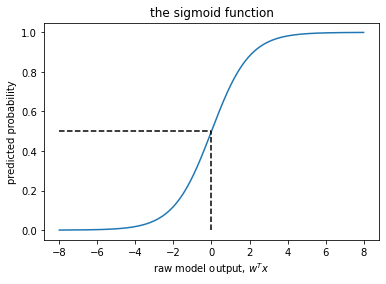

In [27]:
sigmoid = lambda x: 1/(1+np.exp(-x))
raw_model_output = np.linspace(-8,8,1000)
plt.plot(raw_model_output, sigmoid(raw_model_output));
plt.plot([0,0],[0,0.5], '--k')
plt.plot([-8,0],[0.5,0.5], '--k')
plt.xlabel("raw model output, $w^Tx$"); plt.ylabel("predicted probability");plt.title("the sigmoid function");

### Predicting probabilities 

- You can get the probabilities (confidence) of the classifier's prediction using the `model.predict_proba` method. 

In [28]:
lr.predict_proba([example])

array([[0.87848688, 0.12151312]])

Let's examine whether we get the same answer if we call sigmoid on $w^Tx + b$

In [29]:
np.dot(example.tolist(), lr.coef_.flatten()) + (lr.intercept_)

array([-1.97817876])

In [30]:
sigmoid(np.dot(example.tolist(), lr.coef_.flatten()) + (lr.intercept_))

array([0.12151312])

We got the same score! Black magic!

In [31]:
# Predicting probabilities
data_dict = {"y":y_train[:10], 
             "predicted y": lr.predict(X_train[:10]).tolist(),
             "probabilities": lr.predict_proba(X_train[:10]).tolist()}
pd.DataFrame(data_dict)

,y,predicted y,probabilities
160,Canada,Canada,"[0.7046068097086478, 0.2953931902913523]"
127,Canada,Canada,"[0.563016906204013, 0.436983093795987]"
169,Canada,Canada,"[0.8389680973255862, 0.16103190267441386]"
188,Canada,Canada,"[0.796415077540433, 0.20358492245956708]"
187,Canada,Canada,"[0.9010806652340971, 0.09891933476590285]"
192,Canada,Canada,"[0.7753006388010788, 0.22469936119892117]"
62,USA,USA,"[0.03074070460652778, 0.9692592953934722]"
141,Canada,Canada,"[0.6880304799160918, 0.3119695200839082]"
183,Canada,Canada,"[0.7891358587234142, 0.21086414127658581]"
37,USA,USA,"[0.006546969753885357, 0.9934530302461146]"


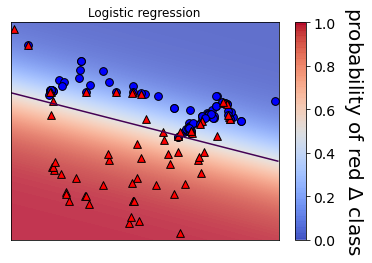

In [32]:
plot_classifier(X_train, y_train, lr, proba=True, ax=plt.gca())
plt.title("Logistic regression");

**Under the hood**

**Odds** describes the ratio of success to ratio of failure.

**Model Evaluation**

We don't always evaluate a model based on accuracy.

A confusion matrix is a table that allows us evaluate the performance of a classification model. You can also visualize the performance of an algorithm. The fundamental of a confusion matrix is the number of correct and incorrect predictions are summed up class-wise.

In [33]:
from sklearn import metrics

y_pred=lr.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[28,  0],
       [ 7,  7]])

In [34]:
TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_pred).ravel()

**Accuracy:** Proportion of correct predictions (both true positives and true negatives) among the total number of cases examined.

In [35]:
accuracy = (TP+TN)/(TN+FP+FN+TP)
accuracy

0.8333333333333334

**Precision:** Fraction of predicted positives that are actually positive.

In [36]:
precision = TP/(TP+FP) 
precision

1.0

**Recall:** Fraction of true positives that are predicted positive

In [37]:
recall = TP/(TP+FN)
recall

0.5

**ROC Curve**  

The Receiver Operating Characteristic curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

Area Under the Curve shows us how good a classifier is: 1 represents perfect classifier, and 0.5 represents a worthless classifier.

The ROC curve is given by the different confusion matrices we can create with one model if we change the threshold.

In [38]:
y_train = y_train.replace('USA', 1)
y_train = y_train.replace('Canada', 0)

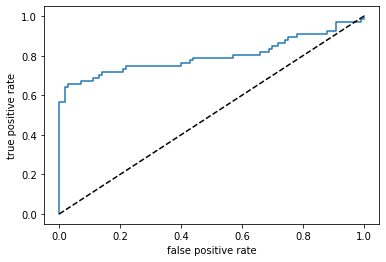

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train)[:,1])

plt.plot(fpr, tpr);
plt.plot((0,1),(0,1),'--k');
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');

In [40]:
auc = metrics.roc_auc_score(y_train, lr.predict_proba(X_train)[:,1])
auc

0.7986567164179105

**NOTE:** I used the training set just so that the curve would look better. Ideally, you would want a nicer curve.

### Interpretability of linear classifiers


- One of the primary advantage of linear classifiers is their ability to interpret models. 
- What features are most useful for prediction? 
- The model has learned coefficient for each feature. 


- In linear models, the $j^{th}$  coefficient tells us how feature $j$ affects the prediction. 
- So looking at the features which have coefficient with bigger magnitudes might be useful.
- Let's sort the coefficients in descending order

#### Limitations of linear classifiers 

- Is your data "linearly separable"? Can you draw a hyperplane between these datapoints that separates them with 0 error. 
    - If the training examples can be separated by a linear decision rule, they are **linearly separable**.

### Multinomial Logistic Regression

- So far we have been talking about binary classification 
- Can we use these classifiers when there are more than two classes? 
    - ["ImageNet" computer vision competition](http://www.image-net.org/challenges/LSVRC/), for example, has 1000 classes 
- Can we use logistic regression for that?

Let's create some synthetic data with two features and four classes. 

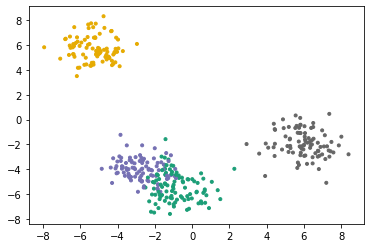

In [41]:
from sklearn.datasets import make_blobs

# generate blobs with fixed random generator
X, y = make_blobs(n_samples=500, centers=4, random_state=300)
X_train, X_test, y_train, y_test = train_test_split(X, y)
plt.scatter(*X_train.T, c=y_train, marker=".", cmap="Dark2");

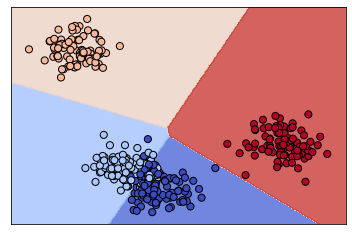

In [42]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
plot_classifier(X_train, y_train, lr);

In [43]:
print("LR classes: ", lr.classes_)
print("Predict proba: ", lr.predict_proba([X_test[0]]))

LR classes:  [0 1 2 3]
Predict proba:  [[7.69968718e-04 7.04227151e-09 1.36868879e-07 9.99229887e-01]]


### Multi-class strategies

- Two common strategies
    - One-vs-rest
    - One-vs-one

By default LogisticRegression uses one-vs-rest strategy to deal with multi-class

### One-vs-rest scheme

- Uses "one-vs-rest" scheme (also known as one-vs-all)
  - turns $k$-class classification into $k$ binary classification problems
  - builds $k$ binary classifiers; for each classifier, the class is fitted against all the other classes
  - each one gives a probability of that class assuming it to be "positive" using the sigmoid function
  - normalize these values across all the classes
  - the class with the maximum value is the prediction 
  - you can do this yourself for any binary classifier using the meta-classifier [`OneVsRestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)

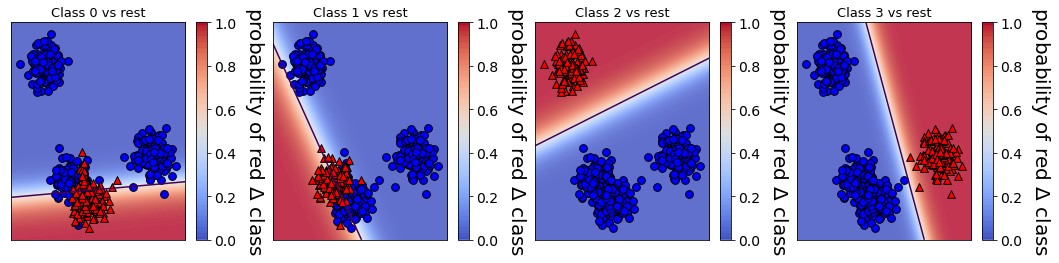

In [44]:
# Here's how one-vs-rest works:
def one_vs_rest_plots(model_class, X, y):
    plt.figure(figsize=(18, 4))
    classes = np.unique(y)
    k = len(classes)
    for i, c in enumerate(classes):
        plt.subplot(1, k, i + 1)

        y_binary = y == c
        model = model_class()
        model.fit(X, y_binary)
        plot_classifier(X, y_binary, model, ax=plt.gca(), proba=True)
        plt.title("Class %d vs rest" % c, fontsize=13)


one_vs_rest_plots(LogisticRegression, X, y)

## Summary

- Logistic regression is a linear classifier; it has one coefficient per feature, plus an intercept. 
- We combine our features and coefficients with a dot product, that is $w_0 + w_1x_1 + w_2x_2 + \ldots + w_dx_d$.
- The decision boundary is a hyperplane dividing the feature space in half.
- You can think of the coefficients as controlling the orientation/tilt of the hyperplane and the bias representing the intercept (offset from the origin). 

**Extra Slides** Will review time allowing.

Things to consider on how Logistic Regression works. Do not lose sleep over these. 

### Odds

The **probability** that an event will occur is the fraction of times you expect to see that event in many trials. 
Probabilities always range between 0 and 1. 

The **odds** are defined as the probability that the event will occur divided by the probability that the event will not occur.  
$\frac{y}{(1-y)}$

* If a race horse runs 100 races and wins 25 times and loses the other 75 times, the probability of winning is 25/100 = 0.25 or 25%. The odds of the horse winning are 25/75 = 0.333 or 1 win to 3 loses.

* If the horse runs 100 races and wins 5 and loses the other 95 times, the probability of winning is 0.05 or 5%, and the odds of the horse winning are 5/95 = 0.0526.

* If the horse runs 100 races and wins 50, the probability of winning is 50/100 = 0.50 or 50%, and the odds of winning are 50/50 = 1 (even odds).

* If the horse runs 100 races and wins 80, the probability of winning is 80/100 = 0.80 or 80%, and the odds of winning are 80/20 = 4 to 1.

What would happen if the horse is too bad at racing? What would happen if the horse is the best? 

If the horse is too bad, the odds of winning will tend to zero.

But if the horse is too good, the odds of winning will be too high.... they can reach infinity... 

How can we compare?

**Log Odds**  
So now that we understand Odds and Probability, we can understand Log Odds. 

Log of Odds is nothing but log(odds). Log Odds makes the magnitude of odds against look so much smaller to those in favor.

When we take a log of odds, we make it look symmetrical.

$Logit Function = log\frac{p}{1-p}$

Odds of winning = 4/6 = 0.6666  
log(Odds of winning) = log(0.6666) = -0.176  
Odds of losing = 6/4 = 1.5  
log(Odds of losing) = log(1.5) = 0.176  

The value of the logit function heads towards infinity as p approaches 1 and towards negative infinity as it approaches 0.

The logit function is useful in analytics because it maps probabilities (which are values in the range [0, 1]) to the full range of real numbers. In particular, if you are working with “yes-no” (binary) inputs it can be useful to transform them into real-valued quantities prior to modeling. This is essentially what happens in logistic regression.

The inverse of the logit function is the sigmoid function. That is, if you have a probability p, sigmoid(logit(p)) = p. The sigmoid function maps arbitrary real values back to the range [0, 1]. 

The larger the value, the closer to 1 you’ll get.